## ch10 Early Stopping
- https://github.com/mattharrison/effective_xgboost_book/blob/main/xgbcode.ipynb

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.7.31</div>
<div style="text-align: right"> Last update: 2023.7.31</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

새롭게 라이브러리를 로드 하자.

In [2]:
import dtreeviz
from feature_engine import encoding, imputation
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, \
    metrics, model_selection, pipeline, preprocessing, tree
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier

import urllib
import zipfile

import xg_helpers as xhelp

In [3]:
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

In [4]:
raw = xhelp.extract_zip(url, fname, member_name)
## Create raw X and raw y
kag_X, kag_y = xhelp.get_rawX_y(raw, 'Q6')

In [5]:
## Split data
kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
model_selection.train_test_split(
kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)

In [6]:
## Transform X with pipeline
X_train = xhelp.kag_pl.fit_transform(kag_X_train)
X_test = xhelp.kag_pl.transform(kag_X_test)
## Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)
# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

In [7]:
X.head()

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat
587,25,18.0,4.0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0
3065,22,16.0,1.0,10000,1,0,0,1,0,0,0,0,1,0,1,0,0,0
8435,22,18.0,1.0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
3110,40,20.0,3.0,125000,1,0,1,0,1,0,0,1,0,0,0,1,0,0
16372,45,12.0,5.0,100000,1,0,1,1,0,0,0,1,0,0,0,1,0,0


In [8]:
y.head()

587      1
3065     0
8435     0
3110     0
16372    1
dtype: int64

early stopping을 사용하면 오버피팅을 줄일수 있다.

### 10.1 Early Stopping Rounds

In [9]:
xg = xgb.XGBClassifier()
xg.fit(X_train, y_train)
xg.score(X_test, y_test)

0.7458563535911602

이제 early_stopping_rounds를 설정해보자.  
그리고 eval_set도 설정해보자. eval_set은 validation data를 지정하는 부분이다. 여기서는 학습, 시험 데이터를 지정한다.  
여기서는 early_stopping_rounds=20으로 설정하였다. 다시말해 20번 rounds(트리)를 진행해서 성능 개선이 없으면 학습을 정지하는 것이다.  
트리수는 디펄트로 100개로 진행한다.


In [10]:
xg = xgb.XGBClassifier(early_stopping_rounds = 20)
xg.fit(X_train, y_train,
       eval_set = [(X_train, y_train),
                   (X_test, y_test)
                   ]
       )

[0]	validation_0-logloss:0.61534	validation_1-logloss:0.61775
[1]	validation_0-logloss:0.57046	validation_1-logloss:0.57623
[2]	validation_0-logloss:0.54011	validation_1-logloss:0.55333
[3]	validation_0-logloss:0.51965	validation_1-logloss:0.53711
[4]	validation_0-logloss:0.50419	validation_1-logloss:0.52511
[5]	validation_0-logloss:0.49176	validation_1-logloss:0.51741
[6]	validation_0-logloss:0.48159	validation_1-logloss:0.51277
[7]	validation_0-logloss:0.47221	validation_1-logloss:0.51040
[8]	validation_0-logloss:0.46221	validation_1-logloss:0.50713
[9]	validation_0-logloss:0.45700	validation_1-logloss:0.50583
[10]	validation_0-logloss:0.45062	validation_1-logloss:0.50430
[11]	validation_0-logloss:0.44533	validation_1-logloss:0.50338
[12]	validation_0-logloss:0.43736	validation_1-logloss:0.50033
[13]	validation_0-logloss:0.43399	validation_1-logloss:0.50034
[14]	validation_0-logloss:0.43004	validation_1-logloss:0.50192
[15]	validation_0-logloss:0.42550	validation_1-logloss:0.50268
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [11]:
xg.score(X_test, y_test)

0.7558011049723757

이제 모델 수를 살펴보자.

In [12]:
xg.best_ntree_limit

13

### 10.2 Plotting Tree Performance

.eval_results() 함수를 실행하면, eval_dataset에 대한 결과를 출력한다.  
- validation_0 is for training data
- validation_1 is for testing data


In [13]:
results = xg.evals_result()
results

{'validation_0': OrderedDict([('logloss',
               [0.6153406503923696,
                0.5704566627034644,
                0.5401074953836288,
                0.519646179894983,
                0.5041859194071372,
                0.49175883369140716,
                0.4815858465553177,
                0.4722135672319274,
                0.46221246084118905,
                0.4570046103131291,
                0.45062119092139025,
                0.44533101600634545,
                0.4373589513231934,
                0.4339914069003403,
                0.4300442738158372,
                0.42550266018419824,
                0.42168949383456633,
                0.41853931894949614,
                0.41485192559138645,
                0.4122836278413833,
                0.4087179538231096,
                0.404898268053467,
                0.4027963532207719,
                0.39941699938733854,
                0.3980718078477953,
                0.39473153180519993,
              

Text(0.5, 0, 'ntrees')

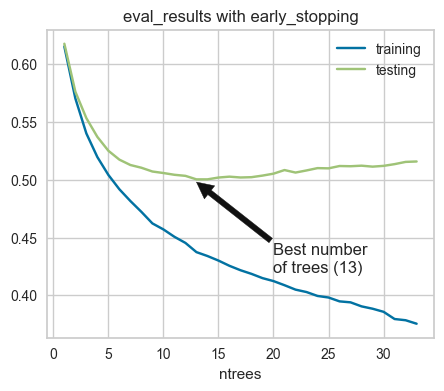

In [14]:
# Testing score is best at 13 trees
results = xg.evals_result()
fig, ax = plt.subplots(figsize=(8, 4))
ax = (pd.DataFrame({'training': results['validation_0']['logloss'],
'testing': results['validation_1']['logloss']})
.assign(ntrees=lambda adf: range(1, len(adf)+1))
.set_index('ntrees')
.plot(figsize=(5,4), ax=ax,
title='eval_results with early_stopping')
)
ax.annotate('Best number \nof trees (13)', xy=(13, .498),
xytext=(20,.42), arrowprops={'color':'k'})
ax.set_xlabel('ntrees')

In [15]:
print(xg.n_estimators)
print(xg.best_ntree_limit)

100
13


early stopping을 하지 않았을 때보다 성능이 좋다.   
오버피팅을 방지해준다.

### 10.3 Different eval_metrics

eval_metric 옵션을 사용하면 평가용 메트릭을 설정할 수 있다.   
분류용 eval_metric은 다음과 같다.  

- Log loss(`loglos`) : 디펄트 값
- AUC(`auc`)  
- Accuracy(`error`)  
- 커스텀 함수도 사용가능

In [16]:
xg_err = xgb.XGBClassifier(early_stopping_rounds = 20,
                           eval_metric = 'error'
                           )
xg_err.fit(X_train, y_train,
       eval_set = [(X_train, y_train),
                   (X_test, y_test)
                   ]
       )

[0]	validation_0-error:0.24739	validation_1-error:0.27072
[1]	validation_0-error:0.24218	validation_1-error:0.26188
[2]	validation_0-error:0.23839	validation_1-error:0.24751
[3]	validation_0-error:0.23697	validation_1-error:0.25193
[4]	validation_0-error:0.23081	validation_1-error:0.24530
[5]	validation_0-error:0.22607	validation_1-error:0.24420
[6]	validation_0-error:0.22180	validation_1-error:0.24862
[7]	validation_0-error:0.21801	validation_1-error:0.24862
[8]	validation_0-error:0.21280	validation_1-error:0.25304
[9]	validation_0-error:0.21043	validation_1-error:0.25304
[10]	validation_0-error:0.20806	validation_1-error:0.24641
[11]	validation_0-error:0.20284	validation_1-error:0.25193
[12]	validation_0-error:0.20047	validation_1-error:0.24420
[13]	validation_0-error:0.19668	validation_1-error:0.24420
[14]	validation_0-error:0.19384	validation_1-error:0.24530
[15]	validation_0-error:0.18815	validation_1-error:0.24199
[16]	validation_0-error:0.18531	validation_1-error:0.24199
[17]	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [17]:
xg_err.best_ntree_limit

19